In [1]:
import os
import pandas as pd
import numpy as np
import random
from deap import base, creator, tools, algorithms

np.random.seed(0)  # for reproducibility
# Get the current working directory
current_directory = os.getcwd()

# Construct the relative path to prediction RUL file
rul_filename = "predicted_RUL_dataset2.csv"
rul_path = os.path.join(current_directory, rul_filename)

# Read the CSV file
rul_df = pd.read_csv(rul_path, delimiter=',')
print(rul_df)


    engine_id  predicted_RUL
0           1            181
1           2            152
2           3             67
3           4             92
4           5            102
..        ...            ...
95         96            130
96         97             92
97         98             78
98         99            139
99        100             33

[100 rows x 2 columns]


In [2]:
# Define constants
M = len(rul_df) # number of engines
G = 4 # Total number of teams (2 type A, 2 type B)
T = 30 # Planning horizon in days
MAX_DAILY_COST = 250
INVALID_PENALTY = 10000

In [3]:
# Define maintenance times for teams A and B
maintenance_duration_a = [4 if i < 20 else 3 if 20 <= i < 55 else 2 if 55 <= i < 80 else 8 for i in range(1, M + 1)]
maintenance_duration_b = [time_a + 1 if i < 25 else time_a + 2 if 25 <= i < 70 else time_a + 1 for i, time_a in enumerate(maintenance_duration_a, start=1)]


# Define engine costs
engine_costs = [4 if i < 21 else 3 if 21 <= i < 31 else 2 if 31 <= i < 46 else 5 if 46 <= i < 81 else 6 for i in range(1, M + 1)]



In [4]:
def generate_random_schedule(T):
    individual = []
    # Track the availability of each team (A and B) on each day
    team_availability = {day: {'A': 0, 'B': 0} for day in range(1, T + 1)}

    # Apply filter to  allocate teams to engines that have a predicted safety due date of less than T = 30.

    filtered_df = rul_df[rul_df['predicted_RUL'] <= T].copy()
    engine_ids = list(filtered_df['engine_id'])
    random.shuffle(engine_ids)

    # print("Engine IDs:", engine_ids)

    # Randomly assign teams to engines within the planning horizon
    for engine_id in engine_ids:
        engine_index = engine_id - 1
        team_type = np.random.choice(['A', 'B'])  # Assume team type is A for this example

        # Determine maintenance duration based on team type
        maintenance_days = maintenance_duration_a[engine_index] if team_type == 'A' else maintenance_duration_b[engine_index]
        valid_start_dates = []

        # Search for valid start dates with continuous available days for maintenance duration
        for start_day in range(1, T - maintenance_days + 2):
            is_valid = True
            for day in range(start_day, start_day + maintenance_days):
                if team_availability[day][team_type] >= 2:  # Check if max team limit is exceeded on any day
                    is_valid = False
                    break
            if is_valid:
                valid_start_dates.append(start_day)

        if not valid_start_dates:
            continue

        start_day = np.random.choice(valid_start_dates)
        end_day = start_day + maintenance_days - 1

        # Update team availability for the selected team and days
        for day in range(start_day, end_day + 1):
            team_availability[day][team_type] += 1

        # Append to individual list
        individual.append((engine_index, team_type, start_day))

    return individual

# Define the problem as a minimization problem
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
# Initialization functions for individual and population.
def init_individual(T):
    return creator.Individual(generate_random_schedule(T))

def init_population(size, T):
    return [init_individual(T) for _ in range(size)]

In [5]:

# Calculates penalty cost per engine
def calculate_penalty(engine_index, team_type, start_day,):
    RUL = rul_df.loc[engine_index, 'predicted_RUL']
    safety_due_date = RUL
    maintenance_days = maintenance_duration_a[engine_index] if team_type == 'A' else maintenance_duration_b[engine_index]
    end_day = start_day + maintenance_days - 1
    penalty = 0

    if end_day > safety_due_date:
        overdue_days = end_day - safety_due_date
        penalty = min(MAX_DAILY_COST, engine_costs[engine_index] * overdue_days ** 2)

    return penalty

# Define the fitness function.
def evaluate(individual):
    """Fitness function for the individual. Returns total penalty cost for the individual"""
    total_penalty = 0
    for engine_index, team_type, start_day in individual:
        penalty = calculate_penalty(engine_index, team_type, start_day)
        total_penalty += penalty

    return (total_penalty,)

# Check invalid individuals
def feasible(individual):
    """Feasibility function for the individual. Returns True if feasible False
    otherwise."""
    team_availability = {day: {'A': 0, 'B': 0} for day in range(1, T + 1)}
    unique_engines = set()
    # Constraints:
    for engine_index, team_type, start_day in individual:
        # An engine can be maintained at most once.
        if engine_index in unique_engines:
            return False

        maintenance_days = maintenance_duration_a[engine_index] if team_type == 'A' else maintenance_duration_b[engine_index]
        end_day = start_day + maintenance_days - 1
        
        # Incomplete schedules are not allowed. 
        if end_day > T:
            return False
        
        # A team can maintain one engine at a time
        for day in range(start_day, end_day + 1):
            if team_availability[day][team_type] >= 2:
                return False
            team_availability[day][team_type] += 1

        unique_engines.add(engine_index)

    return True


In [6]:
# Register genetic algorithm operators
toolbox = base.Toolbox()
toolbox.register("individual", init_individual, T=T)
toolbox.register("population", init_population, size=1000, T=T)
toolbox.register("evaluate", evaluate)
toolbox.decorate("evaluate", tools.DeltaPenalty(feasible, INVALID_PENALTY))
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

# Evolution parameters
ngen = 100  # Generations

# Create the population
pop = toolbox.population(size=1000, T=T)
# Hall of Fame and Statistics
hof = tools.ParetoFront()
stats = tools.Statistics(lambda ind: ind.fitness.values)

# Register statistics
stats.register("avg", np.mean, axis=0)
stats.register("std", np.std, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

In [7]:
pop, logbook = algorithms.eaSimple(pop, toolbox, cxpb=0.7, mutpb=0.05,
                                   ngen=ngen, stats=stats, halloffame=hof)

# Display results
print("Best individual is:", hof[0], hof[0].fitness.values)

gen	nevals	avg      	std           	min  	max    
0  	1000  	[590.309]	[224.80462967]	[18.]	[1378.]
1  	772   	[7601.723]	[4154.68069968]	[18.]	[10000.]
2  	665   	[8056.221]	[3863.98534083]	[18.]	[10000.]
3  	729   	[8428.448]	[3561.678783]  	[18.]	[10000.]
4  	717   	[8687.805]	[3307.81820646]	[18.]	[10000.]
5  	759   	[9017.433]	[2915.80682411]	[62.]	[10000.]
6  	684   	[9132.559]	[2758.6605798] 	[62.]	[10000.]
7  	707   	[9130.7]  	[2764.59566338]	[62.]	[10000.]
8  	696   	[9169.176]	[2708.91688411]	[62.]	[10000.]
9  	725   	[9285.756]	[2527.03365796]	[62.]	[10000.]
10 	714   	[9372.98] 	[2378.5548494] 	[62.]	[10000.]
11 	734   	[9536.562]	[2064.15955831]	[62.]	[10000.]
12 	716   	[9594.594]	[1936.37780331]	[62.]	[10000.]
13 	708   	[9690.599]	[1701.83775731]	[185.]	[10000.]
14 	729   	[9700.359]	[1675.39938406]	[185.]	[10000.]
15 	698   	[9631.592]	[1853.80464492]	[185.]	[10000.]
16 	664   	[9543.251]	[2056.89516359]	[185.]	[10000.]
17 	714   	[9523.088]	[2101.19183852]	[161.]	[10

In [8]:
# Best Solution
best_individual = hof[0]

def convert_best_individual_to_schedule(individual):
    schedule = []
    
    for engine_index, team_type, start_day in individual:
        engine_id = engine_index + 1
        maintenance_days = maintenance_duration_a[engine_index] if team_type == 'A' else maintenance_duration_b[engine_index]
        end_day = start_day + maintenance_days - 1
        RUL = rul_df.loc[engine_index, 'predicted_RUL']
        penalty_cost = calculate_penalty(engine_index, team_type, start_day)
        total_penalty_cost = evaluate(individual)[0]
        schedule.append({
            'Predicted_RUL': RUL,
            'Engine_id': engine_id,
            'Team': team_type, 
            'Start_date': start_day,
            'End_date': end_day,
            'Penalty_cost': penalty_cost,
            'Total_penalty_cost': total_penalty_cost
        })
    
    
    return pd.DataFrame(schedule)
    


schedule_df = convert_best_individual_to_schedule(best_individual)

schedule_df.to_csv('predicted_best_individual.csv', index=False)
schedule_df


,Predicted_RUL,Engine_id,Team,Start_date,End_date,Penalty_cost,Total_penalty_cost
0,15,91,A,5,12,0,18
1,19,31,A,17,19,0,18
2,14,56,B,4,7,0,18
3,21,92,B,11,19,0,18
4,16,66,A,15,16,0,18
5,12,35,A,13,15,18,18
6,29,24,B,4,7,0,18
7,26,76,B,15,17,0,18
8,30,36,A,12,14,0,18
9,29,68,B,22,25,0,18


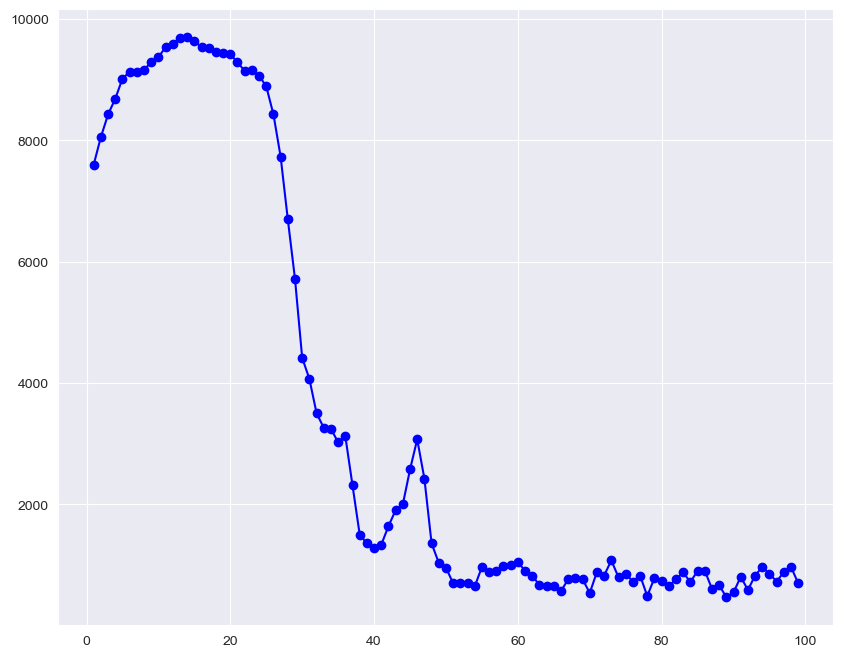

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# History AVG
plt.figure(figsize=(10,8))
front = np.array([(c['gen'], c['avg'][0]) for c in logbook])
plt.plot(front[:,0][1:-1], front[:,1][1:-1], "-bo")
plt.axis("tight")
plt.show()

In [10]:
import pandas as pd

def count_teams_starting_each_day(schedule_df):
    # Initialize a dictionary to hold the count of teams starting work each day
    days_count = {day: 0 for day in range(1, T + 1)}

    # Iterate through each row in the DataFrame
    for index, row in schedule_df.iterrows():
        start_day = row['Start_date']
        if start_day in days_count:
            days_count[start_day] += 1

    # Convert the dictionary to a pandas DataFrame for better readability
    days_count_df = pd.DataFrame(list(days_count.items()), columns=['Day', 'Teams_Starting'])
    
    return days_count_df

# Example usage
# Assume schedule_df is the DataFrame containing the maintenance schedule
days_count_df = count_teams_starting_each_day(schedule_df)

print(days_count_df)


    Day  Teams_Starting
0     1               0
1     2               0
2     3               0
3     4               3
4     5               1
5     6               0
6     7               0
7     8               0
8     9               0
9    10               0
10   11               1
11   12               1
12   13               1
13   14               0
14   15               2
15   16               0
16   17               1
17   18               0
18   19               0
19   20               0
20   21               0
21   22               1
22   23               0
23   24               0
24   25               0
25   26               0
26   27               0
27   28               0
28   29               0
29   30               0


In [11]:
schedule_df.to_csv('predicted_best_individual.csv', index=False)